# Importing the Dependencies'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor as XGB
from sklearn import metrics
import math
from sklearn.utils import shuffle

In [2]:
%matplotlib inline
#import arviz as az
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
#import graphviz
import os

In [5]:
#import pymc3 as pm

# Data Collection and Processing

In [3]:
# loading the data from csv file to pandas dataframe
df = pd.read_csv('/Users/insomni_.ak/Documents/Machine Learning/GIAN_CMC/input/db.csv',index_col=False)

In [4]:
# saving the feature names into a list
f_name=list(df.columns)
lenn=len(f_name)

for i in range(0,lenn):
    print(i, " = ",f_name[i])

0  =  Serial Number !
1  =  Interphase-1
2  =  Coating
3  =  PyC
4  =  SiC
5  =  BN
6  =  Fabrication Temperature 
7  =  Fabrication Time
8  =  Overall Interphase thickness
9  =  Fiber Density
10  =  Fiber Volume Fractions
11  =  Number of Fibers per Tow
12  =  Fiber Radius
13  =  Fiber Tensile Modulus or Young modulus or Tensile Modulus
14  =  Tensile Strength 
15  =  Tensile Young's Modulus
16  =  Tensile Fracture Strain
17  =  Tensile Testing Temperature


In [5]:
#renaming features
df = df.rename(columns={'Fiber Tensile Modulus or Young modulus or Tensile Modulus': 'Fiber Modulus', 'Tensile Strength ': 'Strength','Tensile Fracture Strain':'Strain'})

In [6]:
# inspecting the first 5 rows of the dataframe
df.head()

,Serial Number !,Interphase-1,Coating,PyC,SiC,BN,Fabrication Temperature,Fabrication Time,Overall Interphase thickness,Fiber Density,Fiber Volume Fractions,Number of Fibers per Tow,Fiber Radius,Fiber Modulus,Strength,Tensile Young's Modulus,Strain,Tensile Testing Temperature
0,4.0,PyC,NaN,1,0,0,1000.0,NaN,35.0,NaN,NaN,500.0,6.0,NaN,950.0,NaN,0.2,900.0
1,5.0,PyC,NaN,1,0,0,NaN,NaN,100.0,NaN,0.66,500.0,6.5,354.0,1200.0,350.0,0.7,25.0
2,6.0,NaN,Uncoated,0,0,0,NaN,NaN,NaN,NaN,0.27,400.0,NaN,195.0,NaN,195.0,1.2,NaN
3,NaN,NaN,BN,0,0,1,1400.0,NaN,NaN,NaN,0.27,NaN,NaN,171.0,NaN,176.0,0.8,NaN
4,7.0,PyC,NaN,1,0,0,NaN,NaN,100.0,NaN,0.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.drop(df.columns[[0, 1, 2,7,11,15]], axis=1, inplace=True)

In [8]:
# saving the feature names into a list
f_name=list(df.columns)
lenn=len(f_name)

for i in range(0,lenn):
    print(i, " = ",f_name[i])

0  =  PyC
1  =  SiC
2  =  BN
3  =  Fabrication Temperature 
4  =  Overall Interphase thickness
5  =  Fiber Density
6  =  Fiber Volume Fractions
7  =  Fiber Radius
8  =  Fiber Modulus
9  =  Strength
10  =  Strain
11  =  Tensile Testing Temperature


In [9]:
# checking the number of rows and columns
df.shape

(99, 12)

In [24]:
# getting some information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PyC                           99 non-null     int64  
 1   SiC                           99 non-null     int64  
 2   BN                            99 non-null     int64  
 3   Fabrication Temperature       83 non-null     float64
 4   Overall Interphase thickness  88 non-null     float64
 5   Fiber Density                 66 non-null     float64
 6   Fiber Volume Fractions        88 non-null     float64
 7   Fiber Radius                  72 non-null     float64
 8   Fiber Modulus                 70 non-null     float64
 9   Strength                      93 non-null     float64
 10  Strain                        50 non-null     float64
 11  Tensile Testing Temperature   68 non-null     float64
dtypes: float64(9), int64(3)
memory usage: 9.4 KB


In [25]:
df=shuffle(df)

In [26]:
# checking the number of missing values
df.isnull().sum()

PyC                              0
SiC                              0
BN                               0
Fabrication Temperature         16
Overall Interphase thickness    11
Fiber Density                   33
Fiber Volume Fractions          11
Fiber Radius                    27
Fiber Modulus                   29
Strength                         6
Strain                          49
Tensile Testing Temperature     31
dtype: int64

In [ ]:
# #dealing with the missing values
# #mean
# df.fillna(df.mean(), inplace=True)

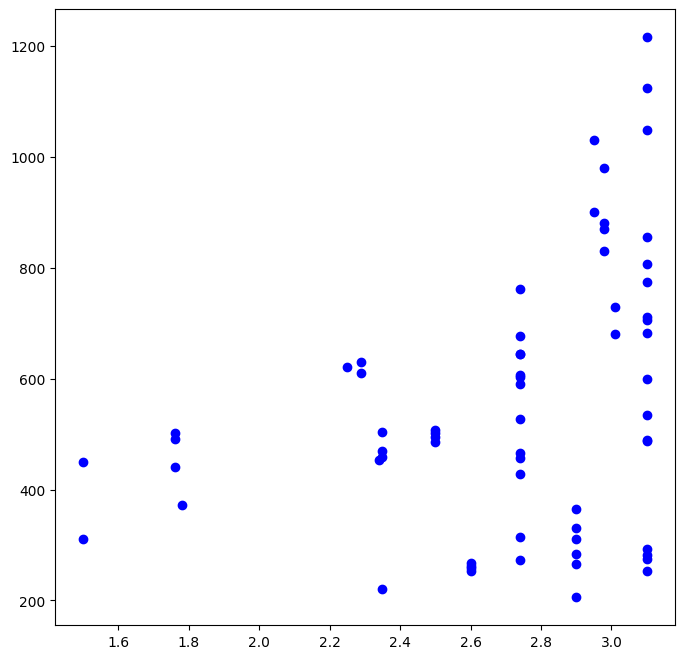

In [11]:
plt.figure(figsize=(8, 8))
plt.plot(df['Fiber Density'], df['Strength'], 'bo')


In [12]:
t=int(input("1 for mean, 2 for -1, 3 for KNeighborsRegressor: "))
if(t==1):
    print("Opted for mean\n")
    df.fillna(df.mean(),inplace=True)
elif(t==2):
    print("Opted for -1\n")
    df.fillna(value=-1,inplace=True)
else:
    print("Opted for KNeighborsRegressor\n")
    from sklearn.neighbors import KNeighborsRegressor

# function that imputes a dataframe
    def impute_knn(df):

        ''' inputs: pandas df containing feature matrix '''
        ''' outputs: dataframe with NaN imputed '''
        # imputation with KNN unsupervised method

        # separate dataframe into numerical/categorical
        ldf = df.select_dtypes(include=[np.number])           # select numerical columns in df
        ldf_putaside = df.select_dtypes(exclude=[np.number])  # select categorical columns in df
        # define columns w/ and w/o missing data
        cols_nan = ldf.columns[ldf.isna().any()].tolist()         # columns w/ nan
        cols_no_nan = ldf.columns.difference(cols_nan).values     # columns w/o nan

        for col in cols_nan:
            imp_test = ldf[ldf[col].isna()]   # indicies which have missing data will become our test set
            imp_train = ldf.dropna()          # all indicies which which have no missing data
            model = KNeighborsRegressor(n_neighbors=5)  # KNR Unsupervised Approach
            knr = model.fit(imp_train[cols_no_nan], imp_train[col])
            ldf.loc[df[col].isna(), col] = knr.predict(imp_test[cols_no_nan])

        return pd.concat([ldf,ldf_putaside],axis=1)
    # Call function that imputes missing data
    df = impute_knn(df)


Opted for KNeighborsRegressor



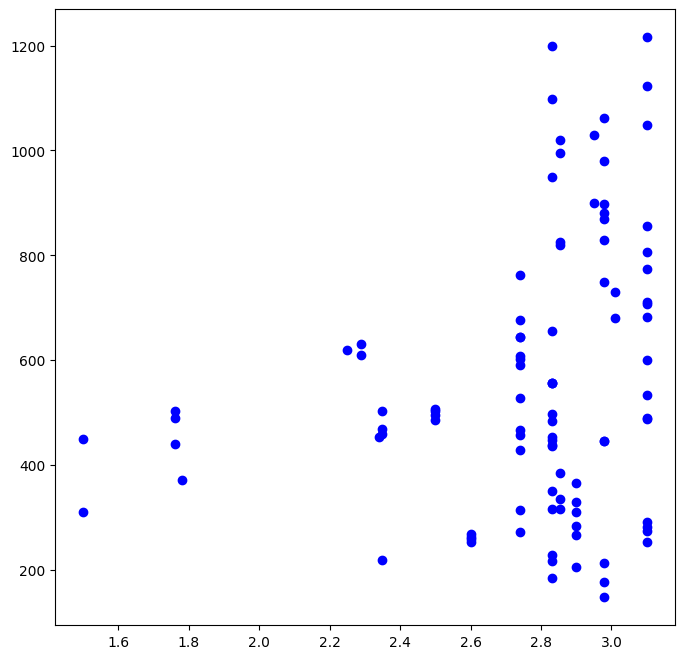

In [13]:
plt.figure(figsize=(8, 8))
plt.plot(df['Fiber Density'], df['Strength'], 'bo');

### Correlation Before Adding more features for Solving Underfitting.

In [14]:
''' Function to plot correlation of features '''
def corrMat(df,id=False):

    corr_mat = df.corr().round(2)
    f, ax = plt.subplots(figsize=(6,6))
    mask = np.zeros_like(corr_mat,dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat,mask=mask,vmin=-1,vmax=1,center=0,
                cmap='plasma',square=False,lw=2,annot=True,cbar=False);plt.show()

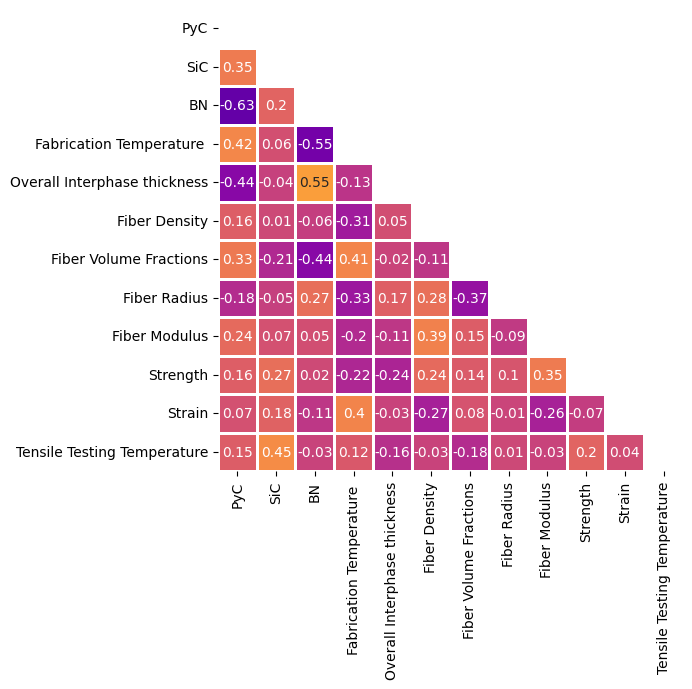

In [15]:
corrMat(df)

### Solving Underfitting

In [ ]:
df['Fiber Radius-2']=df['Fiber Radius']*2+df['Fiber Radius']*3
df['Fiber Volume Fractions-2']=df['Fiber Volume Fractions']*2+df['Fiber Radius-2']
df['Fiber Volume Fractions-3']=df['Fiber Volume Fractions']*3+df['Fiber Radius-2']*2

df['Fiber Modulus-2']=np.sqrt(df['Fiber Modulus'])

In [31]:
# checking the distribution of categorical data
## checking for missing values
df.isnull().sum()

PyC                             0
SiC                             0
BN                              0
Fabrication Temperature         0
Overall Interphase thickness    0
Fiber Density                   0
Fiber Volume Fractions          0
Fiber Radius                    0
Fiber Modulus                   0
Strength                        0
Strain                          0
Tensile Testing Temperature     0
dtype: int64

In [16]:
f_name=list(df.columns)
train=[x for i,x in enumerate(f_name) if i!=9]
test=f_name[9]

In [17]:
train
test

'Strength'

In [18]:
df.head()

,PyC,SiC,BN,Fabrication Temperature,Overall Interphase thickness,Fiber Density,Fiber Volume Fractions,Fiber Radius,Fiber Modulus,Strength,Strain,Tensile Testing Temperature
0,1,0,0,1000.0,35.0,2.830,0.436,6.0,325.0,950.0,0.200,900.0
1,1,0,0,637.6,100.0,2.830,0.660,6.5,354.0,1200.0,0.700,25.0
2,0,0,0,637.6,466.0,2.980,0.270,6.1,195.0,445.6,1.200,25.0
3,0,0,1,1400.0,636.0,2.854,0.270,6.1,171.0,335.8,0.800,25.0
4,1,0,0,637.6,100.0,2.830,0.580,5.8,325.0,556.2,0.616,355.0


In [ ]:
#e




### Distribution Plots

In [ ]:
#features=["Interphase Code","PyC","SiC","BN","Overall Interphase thickness","Fiber Density","Fiber Volume Fractions","Fabrication Temperature "]

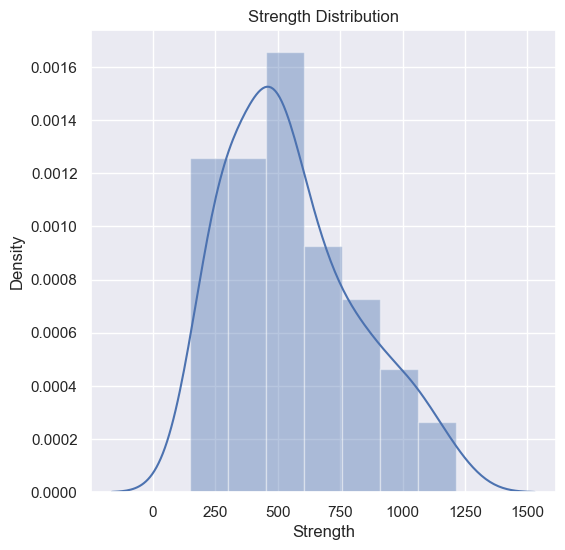

In [19]:
# distribution of strength value
sns.set()
plt.figure(figsize=(6,6))
sns.distplot(df['Strength'])
plt.title('Strength Distribution')
plt.show()

In [ ]:
# # distribution of strength value
# sns.set()
# plt.figure(figsize=(6,6))
# sns.distplot(df['Interphase Code'])
# plt.title('Interphase Code')
# plt.show()

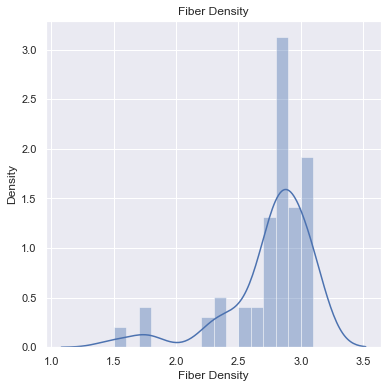

In [ ]:
# distribution of strength value
sns.set()
plt.figure(figsize=(6,6))
sns.distplot(df['Fiber Density'])
plt.title('Fiber Density')
plt.show()

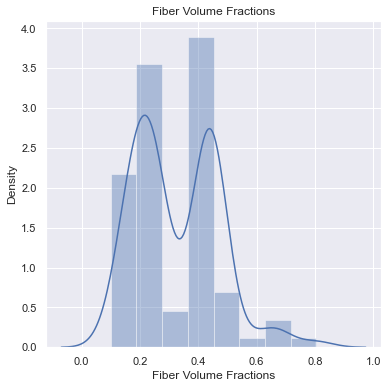

In [ ]:
# distribution of strength value
sns.set()
plt.figure(figsize=(6,6))
sns.distplot(df['Fiber Volume Fractions'])
plt.title('Fiber Volume Fractions')
plt.show()

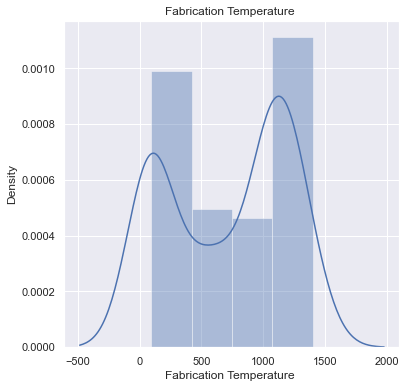

In [ ]:
# distribution of strength value
sns.set()
plt.figure(figsize=(6,6))
sns.distplot(df['Fabrication Temperature '])
plt.title('Fabrication Temperature ')
plt.show()

# Add more features for Underfitting

# Encoding the Categorical Data

### Normalizing/Standardize the Interphase CODE

In [ ]:
# #standardize
# df['Interphase Code'] = (df['Interphase Code'] - df['Interphase Code'].mean()) / df['Interphase Code'].std()

In [ ]:
# #Normalize
# df['Interphase Code'] = df['Interphase Code'] /df['Interphase Code'].abs().max()


# Correlation

In [ ]:
''' Function to plot correlation of features '''
def corrMat(df,id=False):

    corr_mat = df.corr().round(2)
    f, ax = plt.subplots(figsize=(6,6))
    mask = np.zeros_like(corr_mat,dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr_mat,mask=mask,vmin=-1,vmax=1,center=0,
                cmap='plasma',lw=2,annot=True,cbar=False);plt.show()

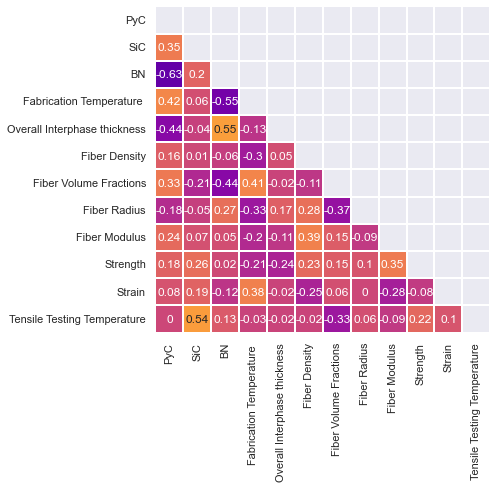

In [ ]:
corrMat(df)

# Splitting the data and Target

In [ ]:
#features=["Interphase Code","PyC","SiC","BN","Overall Interphase thickness","Fiber Density","Fiber Volume Fractions","Fabrication Temperature "]

In [ ]:
# train=["PyC","SiC","BN","Overall Interphase thickness","Fiber Density","Fiber Volume Fractions","Fabrication Temperature "]
# test=["Strength"]

In [24]:
X = df[train]
Y = df[test]

In [25]:
train

['PyC',
 'SiC',
 'BN',
 'Fabrication Temperature ',
 'Overall Interphase thickness',
 'Fiber Density',
 'Fiber Volume Fractions',
 'Fiber Radius',
 'Fiber Modulus',
 'Strain',
 'Tensile Testing Temperature']

In [26]:
print(X)

    PyC  SiC  BN  Fabrication Temperature   Overall Interphase thickness  \
0     1    0   0                    1000.0                          35.0   
1     1    0   0                     637.6                         100.0   
2     0    0   0                     637.6                         466.0   
3     0    0   1                    1400.0                         636.0   
4     1    0   0                     637.6                         100.0   
..  ...  ...  ..                       ...                           ...   
94    1    0   0                    1300.0                         200.0   
95    1    0   0                    1300.0                         200.0   
96    0    0   1                    1050.0                         500.0   
97    0    0   1                    1400.0                         750.0   
98    0    0   1                    1400.0                         450.0   

    Fiber Density  Fiber Volume Fractions  Fiber Radius  Fiber Modulus  \
0           2

In [27]:
print(Y)

0      950.0
1     1200.0
2      445.6
3      335.8
4      556.2
       ...  
94     253.5
95     268.1
96     310.0
97     440.0
98     450.0
Name: Strength, Length: 99, dtype: float64


In [28]:
# Standardize the features
X -= X.mean()
X /= X.std()

In [29]:
print(X)

         PyC       SiC        BN  Fabrication Temperature   \
0   0.877587 -0.422324 -0.965540                  0.595522   
1   0.877587 -0.422324 -0.965540                 -0.153433   
2  -0.646643 -0.422324 -0.965540                 -0.153433   
3  -0.646643 -0.422324  0.772432                  1.422183   
4   0.877587 -0.422324 -0.965540                 -0.153433   
..       ...       ...       ...                       ...   
94  0.877587 -0.422324 -0.965540                  1.215518   
95  0.877587 -0.422324 -0.965540                  1.215518   
96 -0.646643 -0.422324  0.772432                  0.698854   
97 -0.646643 -0.422324  0.772432                  1.422183   
98 -0.646643 -0.422324  0.772432                  1.422183   

    Overall Interphase thickness  Fiber Density  Fiber Volume Fractions  \
0                      -0.977132       0.196311                0.762882   
1                      -0.895973       0.196311                2.344891   
2                      -0.4389

# Cross Validation

In [30]:
from sklearn.model_selection import cross_val_score

In [31]:
lr=sum(cross_val_score(LinearRegression(),X,Y,cv=5))/5

In [32]:
rf=sum(cross_val_score(RandomForestRegressor(n_estimators=50),X,Y,cv=5))/5

In [33]:
xg=sum(cross_val_score(XGB(),X,Y,cv=5))/5

In [42]:
print(lr,rf,xg)

0.28028515206065086 0.6519806710789166 0.5895614073589697


In [34]:
print("Cross Validation Linear Regression = ",lr)

Cross Validation Linear Regression =  -0.932963932066626


In [35]:
print("Cross Validation Random Forest = ",rf)

Cross Validation Random Forest =  -0.05671094529951668


In [45]:
print("Cross Validation XGB = ",xg)

Cross Validation XGB =  0.5895614073589697


# Parameter Tuning

### For Random Forest Regressor

In [ ]:
k_max=-100
n=1

In [ ]:
for i in range(1,100):
    l=(cross_val_score(RandomForestRegressor(n_estimators=i),X,Y,cv=5))
    k=sum(l)/len(l)
    if (k>k_max):
        k_max=k
        n=i

In [ ]:
print(n,k_max)

53 0.5443114746502522


In [ ]:
pt=sum(cross_val_score(RandomForestRegressor(n_estimators=22),X,Y,cv=5))/5

In [ ]:
print("Parameter Tuning = ",pt)

Parameter Tuning =  0.3949002142670489


# Splitting Training and Test data

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=2)

# Model Training

## 1. Linear Regression

In [57]:
# loading the linear regression model
lin_reg_model = LinearRegression()

In [58]:
lin_reg_model.fit(X_train,Y_train)

LinearRegression()

### Model Evaluation

In [59]:

# prediction on Training data
training_data_prediction = lin_reg_model.predict(X_train)

In [60]:
# R squared Error
error_score = metrics.r2_score(Y_train, training_data_prediction)
print("R squared Error : ", error_score)

R squared Error :  0.43254324273137146


#### Visualize the actual Strength and Predicted Strength

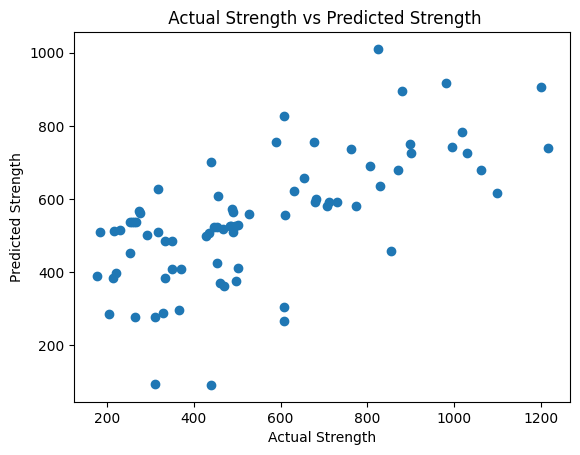

In [61]:
plt.scatter(Y_train, training_data_prediction)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title(" Actual Strength vs Predicted Strength")
plt.show()

In [62]:
Y_train = list(Y_train)

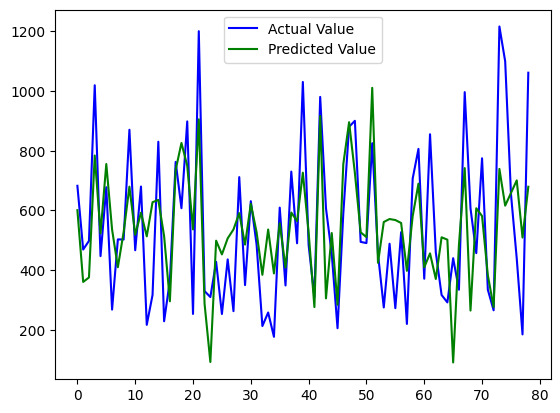

In [63]:
plt.plot(Y_train, color='blue', label = 'Actual Value')
plt.plot(training_data_prediction, color='green', label='Predicted Value')
plt.legend()
plt.show()

In [64]:
# prediction on Test data
test_data_prediction = lin_reg_model.predict(X_test)

In [65]:
# R squared Error
error_score = metrics.r2_score(Y_test, test_data_prediction)
print("R squared Error : ", error_score)

R squared Error :  0.22102835078851757


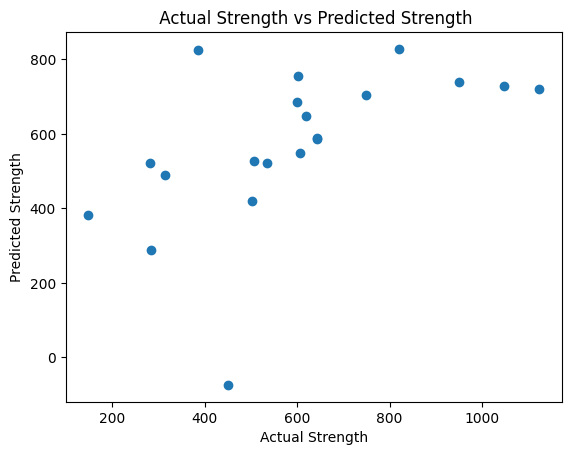

In [66]:
plt.scatter(Y_test, test_data_prediction)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title(" Actual Strength vs Predicted Strength")
plt.show()

In [67]:
Y_test = list(Y_test)

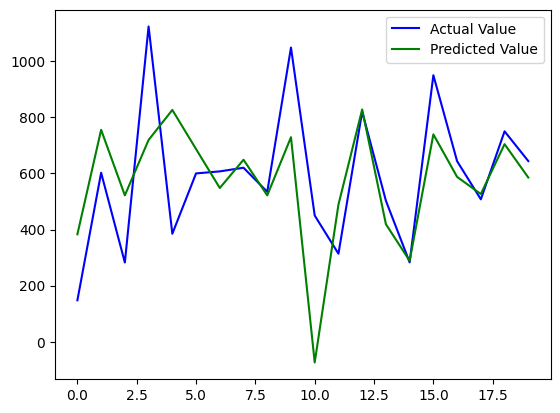

In [68]:
plt.plot(Y_test, color='blue', label = 'Actual Value')
plt.plot(test_data_prediction, color='green', label='Predicted Value')
plt.legend()
plt.show()

## 2. Lasso Regression -- L1 Regularization

In [69]:
# loading the linear regression model
lass_reg_model = Lasso()

In [70]:
lass_reg_model.fit(X_train,Y_train)

Lasso()

### Model Evaluation

In [71]:
# prediction on Training data
training_data_prediction = lass_reg_model.predict(X_train)

In [72]:
# R squared Error
error_score = metrics.r2_score(Y_train, training_data_prediction)
print("R squared Error : ", error_score)

R squared Error :  0.4291960910293764


### Visualize the actual Strength and Predicted Strength

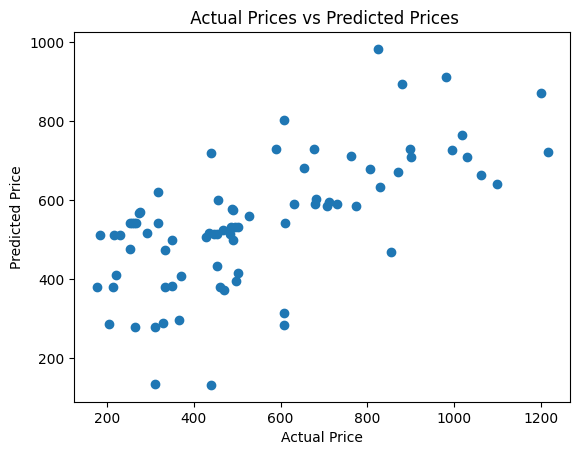

In [73]:
plt.scatter(Y_train, training_data_prediction)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(" Actual Prices vs Predicted Prices")
plt.show()

In [74]:
# prediction on Training data
test_data_prediction = lass_reg_model.predict(X_test)

In [75]:
# R squared Error
error_score = metrics.r2_score(Y_test, test_data_prediction)
print("R squared Error : ", error_score)

R squared Error :  0.2709416095900775


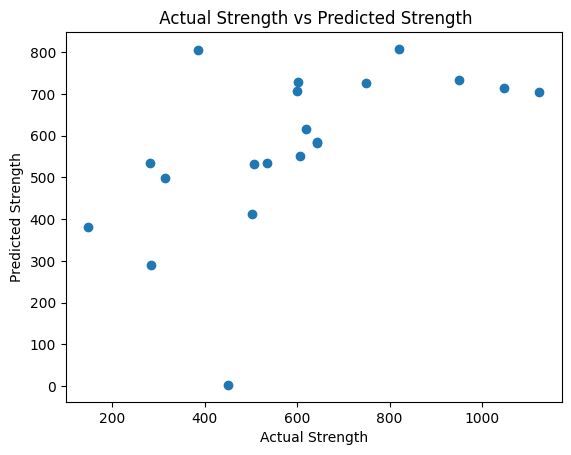

In [76]:
plt.scatter(Y_test, test_data_prediction)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title(" Actual Strength vs Predicted Strength")
plt.show()

## 3. XGBoost Regressor

In [77]:
# loading the model
model = XGB()

In [78]:
# training the model with X_train
model.fit(X_train,Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Evaluation

#### Prediction on train data

In [79]:
# accuracy for prediction on training data
training_data_prediction = model.predict(X_train)

In [80]:
print(training_data_prediction)

[ 682.1696   469.43887  498.05505 1018.9341   446.90652  633.9961
  263.1786   502.9176   502.44214  870.00073  466.6829   680.0133
  216.97774  316.9925   829.9616   229.05531  365.08246  762.2788
  607.37634  898.0126   253.6185  1200.052    329.8868   309.98865
  427.98105  253.2403   435.99893  262.79456  711.69037  349.96423
  630.8879   485.75217  213.15582  263.1786   176.92061  609.3886
  348.78894  729.9822   489.9072  1029.8174   483.93475  287.8548
  980.0268   607.34827  454.09085  205.93152  633.9961   879.99725
  900.17664  494.68372  490.69086  825.00134  453.98343  275.25793
  488.72458  273.21207  526.7582   220.06735  740.543    806.38007
  371.42416  855.0118   459.08115  317.03735  292.08878  440.0231
  334.6376   996.0418   607.31885  456.99585  740.543    334.4964
  287.8548  1215.6116  1098.8169   655.18805  438.91705  185.20355
 1060.9178 ]


In [81]:
# R squared error
score_1 = metrics.r2_score(Y_train, training_data_prediction)

# Mean Absolute Error
score_2 = metrics.mean_absolute_error(Y_train, training_data_prediction)

print("R squared error : ", score_1)
print('Mean Absolute Error : ', score_2)


R squared error :  0.9986999294821508
Mean Absolute Error :  2.7353213153307943


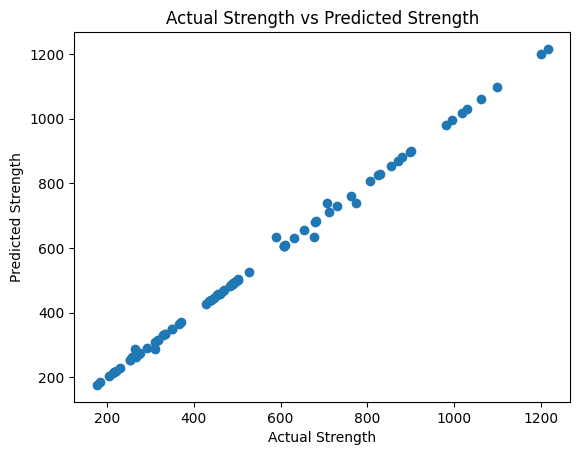

In [82]:
plt.scatter(Y_train, training_data_prediction)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title("Actual Strength vs Predicted Strength")
plt.show()

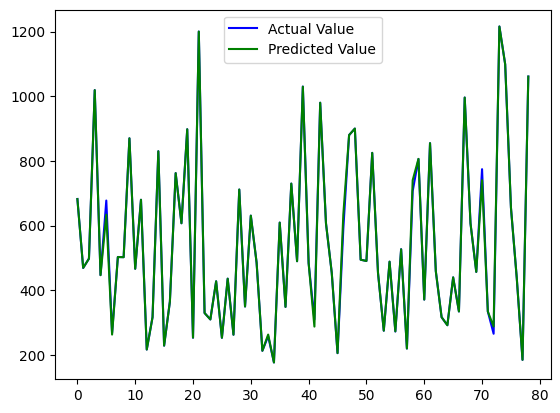

In [83]:
Y_train = list(Y_train)
plt.plot(Y_train, color='blue', label = 'Actual Value')
plt.plot(training_data_prediction, color='green', label='Predicted Value')
plt.legend()
plt.show()

#### Prediction on Test Data

In [84]:
# accuracy for prediction on test data
test_data_prediction = model.predict(X_test)

In [88]:
# R squared error
score_1 = metrics.r2_score(Y_test, test_data_prediction)

# Mean Absolute Error
score_2 = math.sqrt(metrics.mean_squared_error(Y_test, test_data_prediction))

print("R squared error : ", score_1)
print('Mean Squared Error : ', score_2)

R squared error :  0.5255078113364987
Mean Squared Error :  172.1963555414617


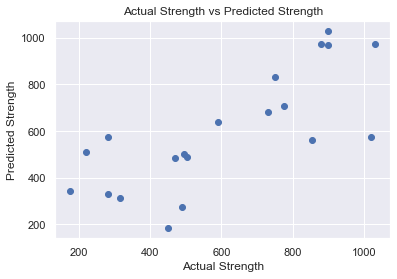

In [ ]:
plt.scatter(Y_test, test_data_prediction)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title("Actual Strength vs Predicted Strength")
plt.show()

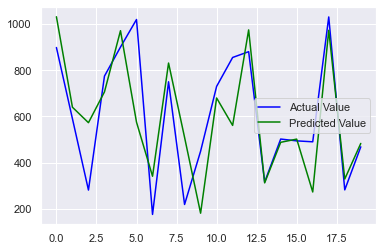

In [ ]:
Y_test = list(Y_test)
plt.plot(Y_test, color='blue', label = 'Actual Value')
plt.plot(test_data_prediction, color='green', label='Predicted Value')
plt.legend()
plt.show()

## 4. Random Forest Regressor

In [36]:
regressor = RandomForestRegressor(n_estimators=100)

In [37]:
# training the model
regressor.fit(X_train,Y_train)

NameError: name 'X_train' is not defined

### Evaluation

#### Prediction on Train Data

In [ ]:
# prediction on Train Data
train_data_prediction = regressor.predict(X_train)

In [ ]:
print(train_data_prediction)

[ 578.4381      594.4044      303.2984      344.5528      465.828
  470.573       430.0854      368.6679      684.9038     1085.198
  548.3701      480.4271      525.8181      399.38326167  875.61542857
  326.6931      699.26655     515.513       399.38326167  287.40095
  265.72263333  728.33896667  345.4998      245.08372     376.0261
  442.5039      465.95442     538.4135      755.3134      897.391
  486.0794      512.3494      938.7032     1050.656       827.48485
  265.65706667  505.9772      689.5         475.9754      611.3507
  357.884       496.1064      936.4067      616.803       936.98
  205.223       254.612       272.676325    450.678       674.7901
  505.3813      299.319925    423.3012      598.8663      292.128
 1061.1468      265.72263333  457.0625     1139.622       259.95733333
  466.6262      511.22        872.9119      265.128       582.7467
  209.9593      399.1433      807.0806      792.323       446.534
  613.102       390.0418      458.896       287.40095     6

In [ ]:
# R squared error
error_score = metrics.r2_score(Y_train, train_data_prediction)
print("R squared error : ", error_score)

R squared error :  0.9303549178702762


#### Prediction on Test Data

In [ ]:
# prediction on Test Data
test_data_prediction = regressor.predict(X_test)

In [ ]:
print(test_data_prediction)

[900.8346     654.61300381 552.5896     582.7467     886.1452
 667.7964     388.806      759.46819667 523.9269     367.42868333
 699.26655    787.7058     908.074      483.9818     469.477
 458.896      401.82423    893.1127     303.2984     514.4444    ]


In [ ]:
# R squared error
error_score2 = metrics.r2_score(Y_test, test_data_prediction)
print("R squared error : ", error_score2)

R squared error :  0.6869644675696644


#### Compare the Actual Values and Predicted Values in a Plot

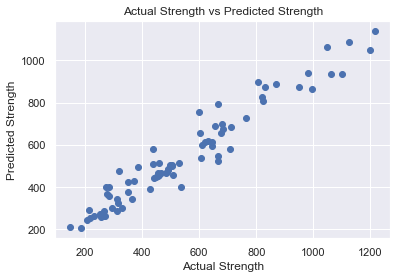

In [ ]:
plt.scatter(Y_train, train_data_prediction)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title("Actual Strength vs Predicted Strength")
plt.show()

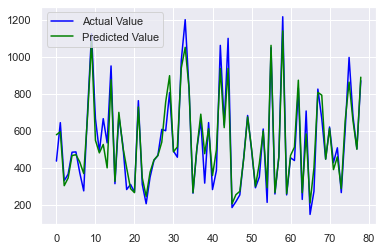

In [ ]:
Y_train = list(Y_train)
plt.plot(Y_train, color='blue', label = 'Actual Value')
plt.plot(train_data_prediction, color='green', label='Predicted Value')
plt.legend()
plt.show()

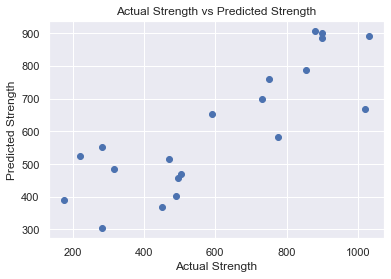

In [ ]:
plt.scatter(Y_test, test_data_prediction)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title("Actual Strength vs Predicted Strength")
plt.show()

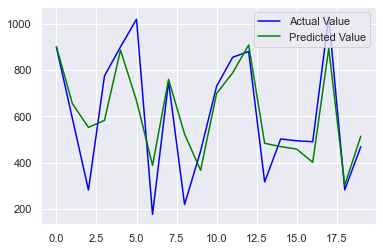

In [ ]:
Y_test = list(Y_test)
plt.plot(Y_test, color='blue', label = 'Actual Value')
plt.plot(test_data_prediction, color='green', label='Predicted Value')
plt.legend()
plt.show()

# 5. Multiple Linear Regression using PyMC 3.0

In [ ]:
X_mean = X.mean(axis=0)

In [ ]:
#X.mean?

In [ ]:
X_centered = X - X_mean

In [ ]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=2) # Try changing the prior distribution
    β = pm.Normal('β', mu=0, sd=5, shape=15) # Note the shape of beta
    ϵ = pm.HalfCauchy('ϵ', 5)

    #likelihood
    μ = α_tmp + pm.math.dot(X_centered, β)
    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=Y)
    #inference
    trace = pm.sample(50, tune=20)

az.summary(trace)

### Lets shuffle for like 1000 times

In [ ]:
lr=[]
rf=[]
xg=[]
for i in range(0,100):
    df=shuffle(df)
    lr.append(sum(cross_val_score(LinearRegression(),X,Y,cv=5))/5)
    rf.append(sum(cross_val_score(RandomForestRegressor(n_estimators=4),X,Y,cv=5))/5)
    xg.append(sum(cross_val_score(XGB(),X,Y,cv=5))/5)






In [ ]:
print(sum(lr)/len(lr))

In [ ]:
print(sum(rf)/len(rf))

In [ ]:
print(sum(xg)/len(xg))

# ANN

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, shuffle=True)

In [ ]:
ann = tf.keras.models.Sequential()

In [ ]:
ann.add(tf.keras.layers.Dense(units=100, activation='relu'))

In [ ]:
ann.add(tf.keras.layers.Dense(units=100, activation='relu'))

In [ ]:
ann.add(tf.keras.layers.Dense(units=1, activation='relu'))

In [ ]:
ann.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['MeanSquaredLogarithmicError'])

In [ ]:
model = ann.fit(X_train, y_train, batch_size = 16, epochs = 1000,validation_data=(X_val, y_val),
              shuffle=True)

In [ ]:
y_pred_train=ann.predict(X_train)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred_train.reshape(len(y_pred_train),1), y_train.values.reshape(len(y_train),1)),1))

In [ ]:
import sklearn.metrics
evs_no=sklearn.metrics.explained_variance_score(y_train,ann.predict(X_train))
me_no=sklearn.metrics.max_error(y_train,ann.predict(X_train))
mae_no=sklearn.metrics.mean_absolute_error(y_train,ann.predict(X_train))
mse_no=sklearn.metrics.mean_squared_error(y_train,ann.predict(X_train))
msle_no=sklearn.metrics.mean_squared_log_error(y_train,ann.predict(X_train))
Mae_no=sklearn.metrics.median_absolute_error(y_train,ann.predict(X_train))
r2_no=sklearn.metrics.r2_score(y_train,ann.predict(X_train))
mpd_no=sklearn.metrics.mean_poisson_deviance(y_train,ann.predict(X_train))
mgd_no=sklearn.metrics.mean_gamma_deviance(y_train,ann.predict(X_train))
mtd_no=sklearn.metrics.mean_tweedie_deviance(y_train,ann.predict(X_train))

In [ ]:
print('Explained Variance Score:',evs_no)
print('Max Error               :',me_no)
print('Mean Absolute Error     :',mae_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('Median Absolute Error   :',Mae_no)
print('R2 Score                :',r2_no)
# print('Mean Poisson Deviance   :',mpd_no)
# print('Mean Gamma Deviance     :',mgd_no)
# print('Mean Tweedie Deviance   :',mtd_no)

In [ ]:
y_pred = ann.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.values.reshape(len(y_test),1)),1))

In [ ]:
import sklearn.metrics
evs_no=sklearn.metrics.explained_variance_score(y_test,ann.predict(X_test))
me_no=sklearn.metrics.max_error(y_test,ann.predict(X_test))
mae_no=sklearn.metrics.mean_absolute_error(y_test,ann.predict(X_test))
mse_no=sklearn.metrics.mean_squared_error(y_test,ann.predict(X_test))
msle_no=sklearn.metrics.mean_squared_log_error(y_test,ann.predict(X_test))
Mae_no=sklearn.metrics.median_absolute_error(y_test,ann.predict(X_test))
r2_no=sklearn.metrics.r2_score(y_test,ann.predict(X_test))
mpd_no=sklearn.metrics.mean_poisson_deviance(y_test,ann.predict(X_test))
mgd_no=sklearn.metrics.mean_gamma_deviance(y_test,ann.predict(X_test))
mtd_no=sklearn.metrics.mean_tweedie_deviance(y_test,ann.predict(X_test))

In [ ]:
print('Explained Variance Score:',evs_no)
print('Max Error               :',me_no)
print('Mean Absolute Error     :',mae_no)
print('Mean Square Error       :',mse_no)
print('Mean Squared Log Error  :',msle_no)
print('Median Absolute Error   :',Mae_no)
print('R2 Score                :',r2_no)
# print('Mean Poisson Deviance   :',mpd_no)
# print('Mean Gamma Deviance     :',mgd_no)
# print('Mean Tweedie Deviance   :',mtd_no)

In [ ]:
# list all data in history
print(model.history.keys())
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(model.history['mean_squared_logarithmic_error'])
plt.plot(model.history['val_mean_squared_logarithmic_error'])
plt.grid()
plt.title('model Mean Squared Logarithmic Error')
plt.ylabel('mean_squared_logarithmic_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()


# Tree based Ensemble Models

## 1. Gradient Boosting

In [ ]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from math import sqrt

model = ensemble.GradientBoostingRegressor(n_estimators=20, max_depth=4, min_samples_leaf=15, min_samples_split=10, learning_rate=0.01, loss='huber', random_state=5)


# Fit model
model.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.01, loss='huber', max_depth=4,
                          min_samples_leaf=15, min_samples_split=10,
                          n_estimators=20, random_state=5)

#### Evalulation

## 2. Ada Boost

## 3.Extreme Gradient Boost (or XGBoost)

## 4. Random Forest (RF)

# Linear Models

## 1.Linear Regression

## 2. LASSO regression

## 3. Ridge Regression

# Kernel Based Methods

## 1. Gaussian Process Regression

## 2. SVM

## Nueral Netowrk

## 1.ANN

Extra Trees Regressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor as et

model = et()
